In [244]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt

In [245]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]]) # 选取前100数据和前两个特征
    for j in range(len(data)):
        if data[j, -1] == 0:
            data[j, -1] = -1 # 将为0的类标签的修改为-1
    
    return data[:, :2], data[:, -1]

In [246]:
X, y =  create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

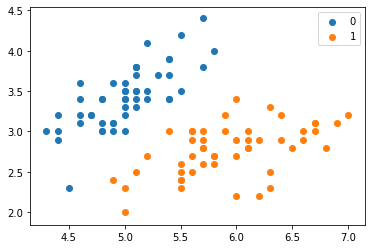

In [247]:
plt.scatter(X[:50, 0],X[:50, 1], label='0')
plt.scatter(X[50:, 0],X[50:, 1], label='1')
plt.legend()

In [248]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.clf_num = n_estimators # 弱分类器的最大数量
        self.learning_rate = learning_rate # 学习率
        self.X = None # 训练数据集data
        self.Y = None # 训练数据集target
        self.M = None # 样本数量
        self.N = None # 特征数量
        self.clf_sets = None # 划分与分类规则(由维度,最优划分点,大于最优划分点target为1还是为-1)组成的列表
        self.weights = None # 训练数据的权值分布
        self.alpha = None # 弱分类器G(\mathcal{x})系数\alpha组成的列表


    def init_param(self, datasets, labels):
        """模型参数初始化"""
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        self.clf_sets = []  
        self.weights = [1.0 / self.M] * self.M  # 初始化weights为均匀分布
        self.alpha = []


    def _G(self, features, labels, weights):
        """构建弱分类器(简单决策树,即所谓的决策树桩)"""
        m = len(features) # 该特征维度下数据的数量
        error = 100000.0
        best_v = 0.0 # 该特征上最优的划分点
        features_min = min(features) # 该特征的最小值
        features_max = max(features)
        n_step = (features_max - features_min +
                  self.learning_rate) // self.learning_rate
        direct = None # 何种划分规则
        compare_array = None # 弱分类器分类结果
        for step in range(1, int(n_step)):
            v = features_min + self.learning_rate * step  # 逐步寻找最优划分点
            compare_array_positive = np.array(
                [1 if features[k] > v else -1 for k in range(m)]) # 根据最优划分点v划分数据集(大于v则target为1,小于等于v则target为-1)
            weight_error_positive = sum([
                weights[k] for k in range(m)
                if compare_array_positive[k] != labels[k]]) # 该划分规则下的分类误差率
                         
            compare_array_nagetive = np.array(
                [-1 if features[k] > v else 1 for k in range(m)])  # 根据最优划分点v划分数据集(大于v则target为-1,小于等于v则target为1)
            weight_error_nagetive = sum([
                weights[k] for k in range(m)
                if compare_array_nagetive[k] != labels[k]])

            if weight_error_positive < weight_error_nagetive: 
                # 若将大于v的数据target设置为1的分类误差率小于按大于v的数据target设置为-1的分类误差率
                weight_error = weight_error_positive
                _compare_array = compare_array_positive
                direct = 'positive'
            else:
                weight_error = weight_error_nagetive
                _compare_array = compare_array_nagetive
                direct = 'nagetive'
            
            if weight_error < error:   
                error = weight_error
                compare_array = _compare_array
                best_v = v
        
        # 返回最优划分点,最优划分规则,最优划分点和最优划分规则下的分类误差率,最优划分点和最优划分规则下对数据类别的划分(即弱分类器分类结果)
        return best_v, direct, error, compare_array 
    
    
    @staticmethod
    def _alpha(error):
        """计算\alpha"""
        print('error:', error)
        return 0.5 * np.log((1 - error) / error)


    def _Z(self, weights, a, clf):
        """计算规范化因子Z_t"""

        return sum([
            weights[i] * np.exp(-1 * a * self.Y[i] * clf[i])
            for i in range(self.M)])


    def _w(self, a, clf, Z):
        """更新训练数据的权值分布"""
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(
                -1 * a * self.Y[i] * clf[i]) / Z


    def fit(self, X, y):
        """学习训练数据集"""
        self.init_param(X, y)
        
        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result, axis, final_direct = 100000, None, None, 0, None
            # 根据特征维度,选择分类误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                v, direct, error, compare_array = self._G(features, self.Y, self.weights)
                print('error::::::', error)
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j

                if best_clf_error == 0:
                    break

            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            self.clf_sets.append((axis, best_v, final_direct))
            Z = self._Z(self.weights, a, clf_result) # 计算规范化因子Z_t
            self._w(a, clf_result, Z) # 权值更新


    @staticmethod
    def G(x, v, direct):
        """基本分类器G_t"""
        if direct == 'positive':
            return 1 if x > v else -1
        else:
            return -1 if x > v else 1


    def predict(self, one_data):
        """预测one_data的target"""
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = one_data[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct) # 基本分类器G_t及其系数\alpha_t的线性组合
        
        return 1 if result > 0 else -1 # 即符号函数


    def score(self, X_test, y_test):
        """计算分类精确度"""
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1

        return right_count / len(X_test)


In [249]:
clf = AdaBoost(n_estimators=50, learning_rate=0.5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test) # 结果受train_test_split的影响

error:::::: 0.15
error:::::: 0.17500000000000002
error: 0.15
error:::::: 0.28431372549019573
error:::::: 0.10294117647058808
error: 0.10294117647058808
error:::::: 0.15846994535519124
error:::::: 0.37021857923497303
error: 0.15846994535519124
error:::::: 0.1754406307977736
error:::::: 0.21996753246753256
error: 0.1754406307977736
error:::::: 0.3031922373787089
error:::::: 0.21816369975608457
error: 0.21816369975608457
error:::::: 0.31486138591402124
error:::::: 0.21853379829055938
error: 0.21853379829055938
error:::::: 0.23182641373817292
error:::::: 0.3685158438955201
error: 0.23182641373817292
error:::::: 0.2857501734217496
error:::::: 0.24875849024578137
error: 0.24875849024578137
error:::::: 0.1960766800605231
error:::::: 0.4354619973141722
error: 0.1960766800605231
error:::::: 0.3432144417439776
error:::::: 0.30107604279908823
error: 0.30107604279908823
error:::::: 0.24553060329946436
error:::::: 0.31441861018960443
error: 0.24553060329946436
error:::::: 0.2771586702661954
error::

0.85

In [250]:
clf.clf_sets # 最终的划分与分类规则

[(0, 5.3, 'positive'),
 (1, 3.0, 'positive'),
 (0, 5.8, 'positive'),
 (0, 4.8, 'nagetive'),
 (1, 2.5, 'positive'),
 (1, 3.5, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, 'positive'),
 (1, 2.5, 'nagetive'),
 (0, 4.8, 'nagetive'),
 (0, 5.8, 'positive'),
 (1, 3.0, 'nagetive'),
 (0, 5.3, '

In [251]:
clf.alpha # 最终所有的\alpha

[0.8673005276940532,
 1.0824818575589998,
 0.8348283862135777,
 0.7737742230475811,
 0.6381998433002386,
 0.6371156075641669,
 0.5990134282099202,
 0.5526223385980517,
 0.7054990419502049,
 0.42108954080405836,
 0.5612965599311833,
 0.4792997890443641,
 0.6290830250048097,
 0.42970367937689613,
 0.3730071110739645,
 0.45711512954057726,
 0.5218902468532861,
 0.5177873787056416,
 0.38831406494324594,
 0.3549138159424266,
 0.4508945051584804,
 0.49316793605693776,
 0.46787789814140673,
 0.37014828974801606,
 0.3722500795418855,
 0.44373312817363125,
 0.47062664118217495,
 0.43121270534308803,
 0.3725965510452322,
 0.3899785232739578,
 0.4400477478363795,
 0.44858882762087193,
 0.41140752958770593,
 0.3814940119037138,
 0.4036281980982704,
 0.4350359747798257,
 0.4315635229534319,
 0.4027245983659895,
 0.3915299449955289,
 0.41186412100759184,
 0.4291271649065207,
 0.41991788223073967,
 0.40076812956517643,
 0.3999397640192287,
 0.41577423689854115,
 0.4232478731253894,
 0.413004996322819

In [252]:
clf.weights # 最终的权值分布



[3.5320078841389172e-06,
 3.5320078841389172e-06,
 3.5320078841389172e-06,
 0.012241537757689012,
 0.017638485274913376,
 0.017638485274913376,
 0.025595232432905613,
 2.068581372946676e-05,
 2.068581372946676e-05,
 0.025595232432905613,
 0.04377514182892962,
 9.877114286256336e-07,
 5.174083768539261e-10,
 9.877114286256336e-07,
 1.4469111730475452e-10,
 0.017638485274913376,
 6.402062709016788e-07,
 0.012241537757689012,
 1.4469111730475452e-10,
 0.049407073557589894,
 0.025595232432905613,
 9.877114286256336e-07,
 3.5320078841389172e-06,
 6.402062709016788e-07,
 9.877114286256336e-07,
 2.068581372946676e-05,
 1.4469111730475452e-10,
 0.017638485274913376,
 2.068581372946676e-05,
 0.017638485274913376,
 0.017638485274913376,
 3.986421655002233e-06,
 6.402062709016788e-07,
 3.5320078841389172e-06,
 3.5320078841389172e-06,
 6.402062709016788e-07,
 0.09152730253934871,
 0.012241537757689012,
 1.4469111730475452e-10,
 0.017638485274913376,
 0.025595232432905613,
 5.174083768539261e-10,
 